# Memory Performance Prediction
Total data size is n=90, consisting of Structural, resting state functional, and diffusion-weighted MRI with Demographic information. 

Each dataset, train and test, includes 'Images' and matched 'Features'; 
- Grey Matter Map (GM)
- White Matter Map (WM)
- Regional Homogeneity Map (ReHo)
- PCG-based Correlation Map (PCGcorr)
- Fractional Anisotropy Map (FA)
- Mean Diffusivity Map (MD)

&rarr; Goal: Predict Memory performance scores.

### Load Label data

In [1]:
import os
import pandas as pd
from functools import reduce
import numpy as np

root_dir = '/home/jiwon/MedicalBioResearch/Prediction_Memory/'
os.chdir(root_dir)
os.getcwd()

'/home/jiwon/MedicalBioResearch/Prediction_Memory'

In [2]:
# Defining Paths for Training Data
feature_data = 'data/features/'
train_data_path = root_dir+feature_data+'train/'

predictors_paths = {
    'GM': os.path.join(train_data_path, 'GM.csv'),
    'WM': os.path.join(train_data_path, 'WM.csv'),
    'ReHo': os.path.join(train_data_path, 'ReHo.csv'),
    'PCGcorr': os.path.join(train_data_path, 'PCGcorr.csv'),
    'FA': os.path.join(train_data_path, 'FA.csv'),
    'MD': os.path.join(train_data_path, 'MD.csv')
}
additional_variables_path = os.path.join(train_data_path, 'Subjects.csv')

print(predictors_paths['GM'])
print(additional_variables_path)

/home/jiwon/MedicalBioResearch/Prediction_Memory/data/features/train/GM.csv
/home/jiwon/MedicalBioResearch/Prediction_Memory/data/features/train/Subjects.csv


In [3]:
# Selecting Specific Modalities
modalities = ['GM', 'ReHo', 'MD']
selected_modalities = {modality: predictors_paths[modality] for modality in modalities if modality in predictors_paths}

# Reading and Renaming Data (except 'ID' column)
def read_and_rename(modality, path):
    df = pd.read_csv(path)
    df = df.rename(columns={label: f"{label}_{modality}" for label in df.columns if label != 'ID'})
    # print('[ '+modality+' ]')
    # print(df.columns)
    # print('\n')
    return df
dfs = [read_and_rename(modality, path) for modality, path in selected_modalities.items()]

# Merging All Data Frames
predictors_df = reduce(lambda left, right: pd.merge(left, right, on='ID'), dfs)

In [4]:
#  Response and Confounding Variables
additional_variables = ['Memory', 'Age', 'Sex', 'EducationYear']
df = pd.read_csv(additional_variables_path)
print(df.head())
selected_variables = [variable for variable in additional_variables if variable in df.columns]
additional_variables_df = df[["ID"] + selected_variables]

# Merging Dataframes and Saving to CSV
df = pd.merge(additional_variables_df, predictors_df, on='ID')
# print(df.head())
df.to_csv(train_data_path+'Edited_df_'+'+'.join(modalities) + '.csv', index=False)

# Prepare X and y
X = df.drop(columns=['ID', 'Memory'])   # All variables except 'ID' and  'Memory'
y = df['Memory']    # A response variable, 'Memory'

   ID   Memory  Age  Sex  EducationYear
0   1  0.28039   78    0              7
1   2  0.81263   81    0             16
2   3 -0.55341   84    0              7
3   4  0.34263   78    0             12
4   5  0.47084   74    0             10


### Select Features

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Sample size for training: {X_train.shape[0]}')
print(f'Sample size for test: {X_test.shape[0]}')

Sample size for training: 64
Sample size for test: 16


In [7]:
def feature_selection(feature_selection_method):
    if feature_selection_method == 'Lasso':
        # Lasso regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
        print(f'Regularization strength hyperparameter for Lasso: {lasso.alpha_:.3f}')
        selector = SelectFromModel(lasso, prefit=True)
        X_train_selected = selector.transform(X_train)
    elif feature_selection_method == 'MI':
        # Mutual information
        selector = SelectPercentile(mutual_info_regression, percentile=50)
        X_train_selected = selector.fit_transform(X_train, y_train)
    
    selected_mask = selector.get_support()
    print(f"Selected features by {feature_selection_method}: {selected_mask.sum()} out of {X_train.shape[1]} total features")
    selected_features = X_train.columns[selected_mask]
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
    X_test_selected = pd.DataFrame(selector.transform(X_test), columns=selected_features)
    return selected_features, X_train_selected, X_test_selected, selector

In [8]:
feature_selection_method = 'Lasso' # 'Lasso' or 'MI'
selected_features, X_train_selected, X_test_selected, selector = feature_selection(feature_selection_method)

Regularization strength hyperparameter for Lasso: 0.096
Selected features by Lasso: 10 out of 171 total features


### Train Model

In [9]:
# Hyperparameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 7],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8], # Number of features to consider when looking for the best split
    'bootstrap': [False] # Whether bootstrap samples are used when building trees
}
# Hyperparameter grid for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
# Hyperparameter grid for XGBRegressor
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  # Number of gradient boosted trees (boosting rounds)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 6, 9, 12],  # Maximum depth of each tree
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 0.7, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 2, 5]  # L2 regularization term on weights
}

In [10]:
def cross_validation_score(ml_method):
    if ml_method == 'ET':
        regressor = ExtraTreesRegressor(random_state=42)
        param_grid=param_grid_et
        # grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_et, cv=5, scoring='neg_mean_absolute_error')
    elif ml_method == 'RF':
        regressor = RandomForestRegressor(random_state=42)
        param_grid=param_grid_rf
        # grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
    elif ml_method == 'XGB':
        regressor = XGBRegressor(random_state=42)
        param_grid=param_grid_xgb
        # grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error')
    
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f'Best cross-validation score {-grid_search.best_score_:.3f} by {ml_method} for hyperparameters: ', best_params)
    print(f'(Feature Selection Method: {feature_selection_method})\n')
    return best_params

In [11]:
best_params_dict = {}
ml_methods = ['ET', 'RF']#, 'XGB']
for ml_method in ml_methods:
    best_params_dict[ml_method] = cross_validation_score(ml_method)

Best cross-validation score 0.299 by ET for hyperparameters:  {'bootstrap': False, 'max_depth': 10, 'max_features': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
(Feature Selection Method: Lasso)

Best cross-validation score 0.316 by RF for hyperparameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
(Feature Selection Method: Lasso)



### Test Model

In [12]:
for ml_method in ml_methods:
    best_params = best_params_dict[ml_method]
    if ml_method == 'ET':
        regressor = ExtraTreesRegressor(**best_params)
    elif ml_method == 'RF':
        regressor = RandomForestRegressor(**best_params)
    elif ml_method == 'XGB':
        regressor = XGBRegressor(**best_params)
    regressor.fit(X_train_selected, y_train)

    # Save the model to the disk
    import pickle
    with open(f'{ml_method}_model_{feature_selection_method}.pkl', 'wb') as f:
        pickle.dump(regressor, f)

    predictions = regressor.predict(X_test_selected)
    mae = mean_absolute_error(y_test, predictions)
    print(f"MAE by {ml_method}: {mae:.3f}")
    print(f'(Feature Selection Method: {feature_selection_method})\n')

MAE by ET: 0.369
(Feature Selection Method: Lasso)

MAE by RF: 0.379
(Feature Selection Method: Lasso)



### Feature Importances

In [13]:
for ml_method in ml_methods:
    # Load the model from disk
    with open(f'{ml_method}_model_{feature_selection_method}.pkl', 'rb') as f:
        regressor = pickle.load(f)
    
    feature_importances = regressor.feature_importances_
    features_and_importances = zip(selected_features, feature_importances)
    sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)
    top_features_and_importances = sorted_features_and_importances[:9]
    print(f"Top features' importances by {ml_method}:")
    for no, feature_importance in enumerate(top_features_and_importances):
        print(f"{no + 1}. {feature_importance[0]}: {feature_importance[1]:.3f}")
        print()

Top features' importances by ET:
1. GyrusRectusR_GM: 0.132

2. AmbientAndParahippocampusGyriL_ReHo: 0.106

3. SuperiorTemporalGyrusR_GM: 0.101

4. GyrusRectusR_ReHo: 0.100

5. MiddleCerebellarPeduncle_MD: 0.098

6. CorticospinalTractL_MD: 0.098

7. AnteriorCingulateGyrusR_GM: 0.094

8. PallidumR_ReHo: 0.093

9. PrecentralGyrusR_ReHo: 0.089

Top features' importances by RF:
1. AmbientAndParahippocampusGyriL_ReHo: 0.159

2. GyrusRectusR_GM: 0.135

3. AccumbensNucleusL_GM: 0.110

4. CorticospinalTractL_MD: 0.097

5. PallidumR_ReHo: 0.093

6. SuperiorTemporalGyrusR_GM: 0.090

7. PrecentralGyrusR_ReHo: 0.086

8. MiddleCerebellarPeduncle_MD: 0.085

9. GyrusRectusR_ReHo: 0.082



### SHAP (SHapley Additive exPlanations)

In [14]:
# import os
# import pickle

# root_dir = '/home/jiwon/MedicalBioResearch/Prediction_Memory/'
# os.chdir(root_dir)
# os.getcwd()

# ml_methods = ['ET', 'RF']#, 'XGB']
# feature_selection_method = 'Lasso' # 'Lasso' or 'MI'

SHAP summary plot for ET:


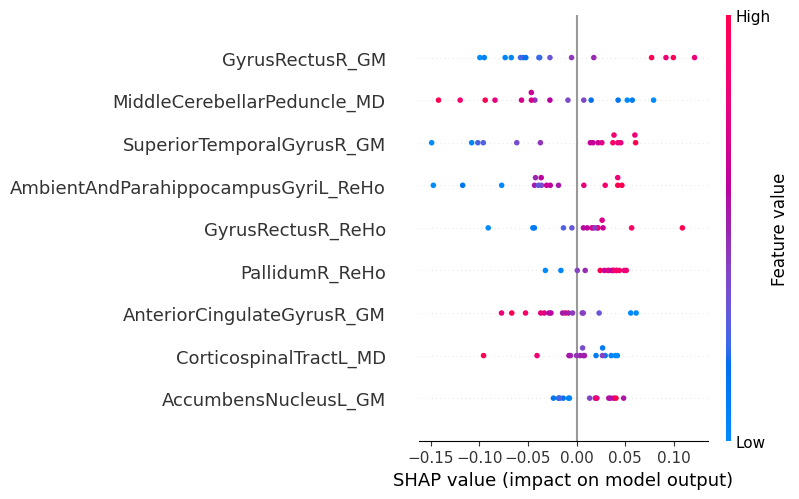

SHAP summary plot for RF:


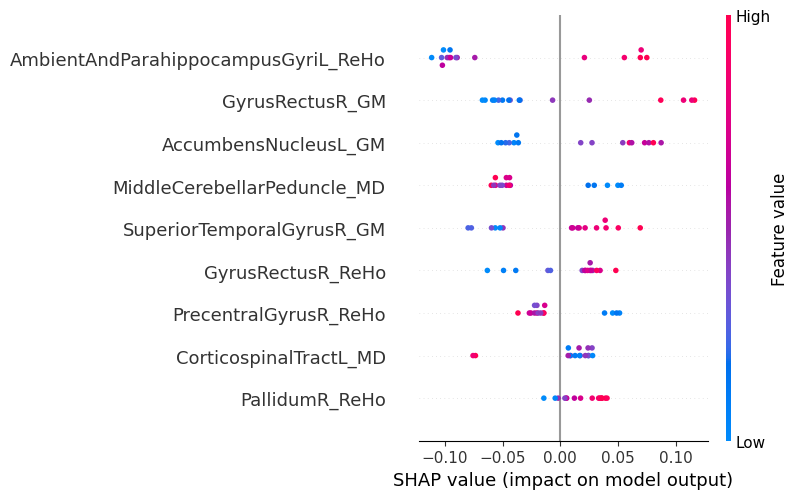

In [15]:
import shap
import matplotlib

shap.initjs()   # Initialize SHAP

# Dictionary to store SHAP explainers for each model
explainers = {}

for ml_method in ml_methods:
    # Load the model from disk
    with open(f'{ml_method}_model_{feature_selection_method}.pkl', 'rb') as f:
        regressor = pickle.load(f)

    # Create SHAP explainer and calculate SHAP values
    explainer = shap.Explainer(regressor)
    explainers[ml_method] = explainer
    shap_values = explainer(X_test_selected)

     # Generate SHAP summary plot
    shap.initjs()
    print(f"SHAP summary plot for {ml_method}:")
    shap.summary_plot(shap_values, X_test_selected, max_display=9)


### Inference

In [16]:
# Defining Paths for Test Data
feature_data = 'data/features/'
test_data_path = root_dir+feature_data+'test/'

predictors_paths = {
    'GM': os.path.join(train_data_path, 'GM.csv'),
    'WM': os.path.join(train_data_path, 'WM.csv'),
    'ReHo': os.path.join(train_data_path, 'ReHo.csv'),
    'PCGcorr': os.path.join(train_data_path, 'PCGcorr.csv'),
    'FA': os.path.join(train_data_path, 'FA.csv'),
    'MD': os.path.join(train_data_path, 'MD.csv')
}
additional_variables_path = os.path.join(train_data_path, 'Subjects.csv')

print(predictors_paths['GM'])
print(additional_variables_path)

/home/jiwon/MedicalBioResearch/Prediction_Memory/data/features/train/GM.csv
/home/jiwon/MedicalBioResearch/Prediction_Memory/data/features/train/Subjects.csv


In [17]:
# Predictors
selected_modalities = {modality: predictors_paths[modality] for modality in modalities if modality in predictors_paths}
dfs = [read_and_rename(modality, path) for modality, path in selected_modalities.items()]
predictors_df = reduce(lambda left, right: pd.merge(left, right, on='ID'), dfs)

In [27]:
print(np.shape(X))
print(np.shape(X_ext))

(80, 171)
(80, 172)


   ID   Memory  Age  Sex  EducationYear
0   1  0.28039   78    0              7
1   2  0.81263   81    0             16
2   3 -0.55341   84    0              7
3   4  0.34263   78    0             12
4   5  0.47084   74    0             10 

MAE by ET: 0.101
(Feature Selection Method: Lasso)



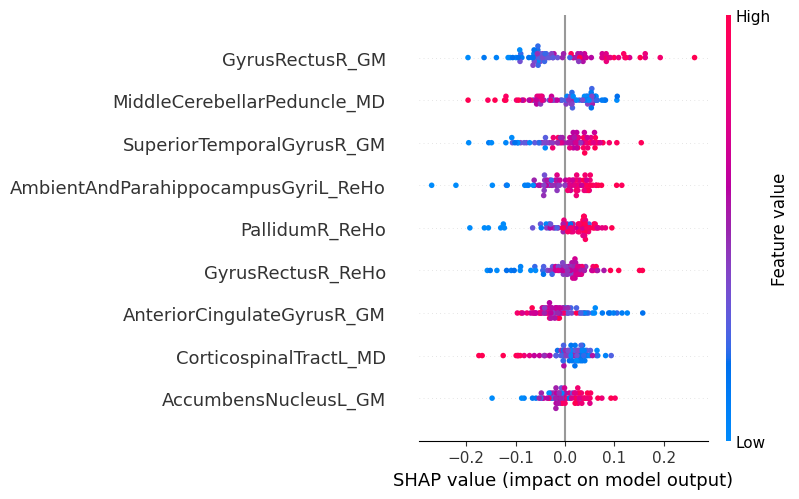

MAE by RF: 0.243
(Feature Selection Method: Lasso)



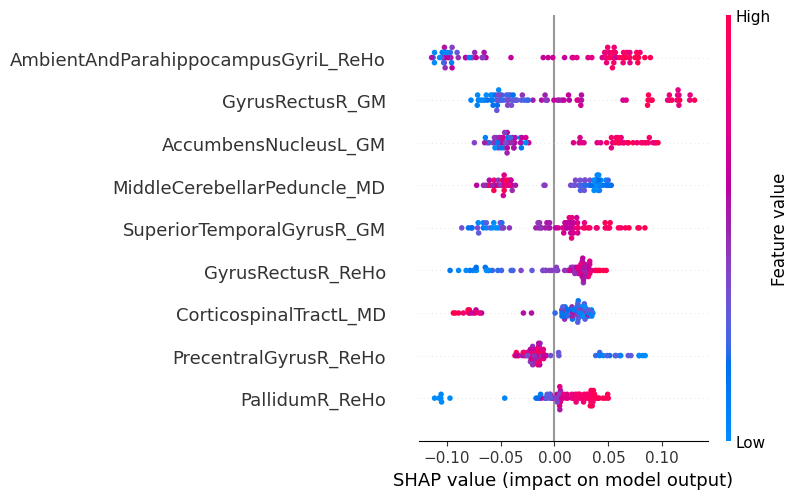

In [33]:
#  Confounding Variables
df = pd.read_csv(additional_variables_path)
print(df.head(), '\n')
selected_variables = [variable for variable in additional_variables if variable in df.columns]
additional_variables_df = df[["ID"] + selected_variables]

# Merging predictors with confounding variables on 'ID'
df = pd.merge(additional_variables_df, predictors_df, on='ID')
# print(df.head())
df.to_csv(train_data_path+'+'.join(modalities) + '_test.csv', index=False)

# Apply trained model
y_ext = df['Memory']
X_ext = df.drop(columns=['ID', 'Memory'])
X_ext_selected = pd.DataFrame(selector.transform(X_ext), columns=selected_features)

for ml_method in ml_methods:
    # Load the model from disk
    with open(f'{ml_method}_model_{feature_selection_method}.pkl', 'rb') as f:
        regressor = pickle.load(f)

    predictions_ext = regressor.predict(X_ext_selected)
    filename = os.path.join(test_data_path, '_'.join(["Predictions", ml_method, feature_selection_method,''])+'+'.join(modalities)+".txt")
    np.savetxt(filename, predictions_ext)

    # MAE
    mae = mean_absolute_error(y_ext, predictions_ext)
    print(f"MAE by {ml_method}: {mae:.3f}")
    print(f'(Feature Selection Method: {feature_selection_method})\n')   

    # SHAP
    explainer = explainers[ml_method]
    shap_values = explainer(X_ext_selected)
    shap.initjs()
    shap.summary_plot(shap_values, X_ext_selected, max_display=9)

